In [1]:
CUDA_VISIBLE_DEVICES = '3'

In [1]:
import os
os.chdir('..')


In [2]:
from Losses.AdversarialLoss import calc_Dw_loss
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Attribute_Encoder import Encoder_Attribute
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Losses.NonAdversarialLoss import id_loss,landmark_loss,rec_loss
from Models.StyleGan2.model import Generator
from Utils.data_utils import plot_single_w_image, get_w_image,Image_W_Dataset, cycle_images_to_create_diff_order
from Training.trainer import Trainer
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from argparse import Namespace
import sys
import time
import numpy as np
from PIL import Image
sns.set()

In [25]:
BASE_PATH = './pretrained/'
GENERATOR_WEIGHTS_PATH = BASE_PATH + '800000.pt'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/image_med_res/'
W_DATA_DIR = BASE_PATH + 'Dataset/w_med_res/'

In [26]:
generator = Generator(512,512,8).cuda()
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

_IncompatibleKeys(missing_keys=['convs.12.conv.weight', 'convs.12.conv.blur.kernel', 'convs.12.conv.modulation.weight', 'convs.12.conv.modulation.bias', 'convs.12.noise.weight', 'convs.12.activate.bias', 'convs.13.conv.weight', 'convs.13.conv.modulation.weight', 'convs.13.conv.modulation.bias', 'convs.13.noise.weight', 'convs.13.activate.bias', 'to_rgbs.6.bias', 'to_rgbs.6.upsample.kernel', 'to_rgbs.6.conv.weight', 'to_rgbs.6.conv.modulation.weight', 'to_rgbs.6.conv.modulation.bias', 'noises.noise_13', 'noises.noise_14'], unexpected_keys=[])

In [29]:
generator = generator.eval()
NUMBER_OF_IMAGES = 15000

In [30]:
counter = 0
cur_dir = 0
num_of_images_in_single_loop = 10
for i in tqdm(range(NUMBER_OF_IMAGES//num_of_images_in_single_loop)):
    torch.cuda.empty_cache()
    with torch.no_grad():
        sample_z = torch.randn(num_of_images_in_single_loop, 512, device='cuda')
        sample, latents = generator(
            [sample_z], input_is_latent=False, return_latents=True, truncation= 1, truncation_latent = None
        )

    latents = latents.cpu().detach().numpy()


    for index in range(len(sample)):
        if (counter % 1000) == 0:
            Path(f"{W_DATA_DIR}{int(counter / 1000)}").mkdir(parents=True, exist_ok=True)
            Path(f"{IMAGE_DATA_DIR}{int(counter / 1000)}").mkdir(parents=True, exist_ok=True)
            cur_dir = int(counter / 1000)

        with open(f'{W_DATA_DIR}{cur_dir}/{counter}.npy', 'wb') as f:
            np.save(f, latents[index][0])

        utils.save_image(
                    sample[index],
                    f'{IMAGE_DATA_DIR}{cur_dir}/{counter}.png',
                    nrow=1,
                    normalize=True,
                    range=(-1, 1),
                )


    counter+=1

100%|██████████████████████████████████████████████| 1500/1500 [31:25<00:00,  1.26s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


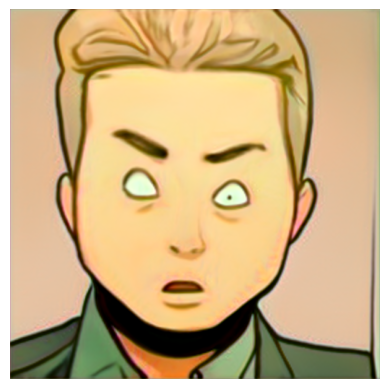

In [13]:
fake_w = np.load(f'{W_DATA_DIR}0/71.npy')
fake_w = torch.from_numpy(fake_w)
plot_single_w_image(fake_w, generator)